# Assignment 4 - Solution of Mass and Momentum Equations

Solve the following problems and explain your results.

Solve all problems using water as the fluid with $\rho=1000$ [kg/m$^3$], $\mu=1 \times 10^{-3}$ [kg/m$\cdot$s].  Problems 1-2 should be solved for a 4 [m] long, 0.02 $\times$ 0.02 [m] cross-section duct discretized using 10 equal-length control-volumes.  Also, for simplicity, use UDS as your advection scheme for problems 1-2.  Higher-order advection schemes are considered in question 3.

Heat transfer is not considered in these problems, so the energy equation does not need to be solved.

## Problem 1

For $\tau_w=0$, set $u = \hat{u} = 10$ [m/s] and $p = 0$ [Pa] everywhere as initial conditions.  These are the exact solutions to the mass and momentum equations for constant duct area.  Do one time step (using any time step size) and make sure that your code accepts this as the exact solution.  Repeat this problem with $u = \hat{u} = -10$ [m/s] to ensure that your code has no directional dependence.  Describe the boundary conditions used for the two cases, including the values of $\alpha_e$.

In [181]:
import numpy

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, phi, phiold, rho, const, dt):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._phiold = phiold
        self._rho = rho
        self._const = const
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._const*self._grid.vol*(self._phi[1:-1]-self._phiold[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._const*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs

In [182]:
class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, const, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._const = const
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._const*mdote[:-1]*self._phie[:-1]
        flux_e = self._const*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._const*mdote[1:]*self._phi[1:-1] + self._const*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._const*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._const*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [183]:
class AdvectingVelocityModel:
    """Class defining an advecting velocity model"""

    def __init__(self, grid, dhat, Uhe, P, U, coeffs):
        """Constructor"""
        self._grid = grid
        self._dhat = dhat
        self._Uhe = Uhe
        self._P = P
        self._U = U
        self._coeffs = coeffs

    def update(self):
        """Function to update the advecting velocity array"""

        # Calculate the pressure gradients across the faces
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        
        # Calculate the cell pressure gradients
        gradP = 0.5*(gradPw + gradPe)
          
        # Calculate damping coefficient, dhat
        Ve = 0.5*(self._grid.vol[0:-1] + self._grid.vol[1:])
        ae = 0.5*(self._coeffs.aP[0:-1] + self._coeffs.aP[1:])
        self._dhat[1:-1] = Ve/ae

        # Update the advecting velocity
        self._Uhe[0] = self._U[0]
        self._Uhe[1:-1] = 0.5*(self._U[1:-2] + self._U[2:-1]) - self._dhat[1:-1]*(gradPe[:-1] - 0.5*(gradP[:-1] + gradP[1:]))
        self._Uhe[-1] = self._U[-1]

In [184]:
class PressureForceModel:
    """Class defining a pressure force model"""

    def __init__(self, grid, P, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._P = P
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the pressure force
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        force = 0.5*(gradPw + gradPe)*self._grid.vol
          
        # Calculate the linearization coefficients
        coeffW = - 0.5*self._grid.vol/self._grid.dx_WP
        coeffE = 0.5*self._grid.vol/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(force)

        # Return the modified coefficient array
        return coeffs

In [185]:
class MassConservationEquation:
    """Class defining a mass conservation equation"""

    def __init__(self, grid, U, P, dhat, Uhe, rho, 
                 P_west_bc, P_east_bc, U_west_bc, U_east_bc):
        """Constructor"""
        self._grid = grid
        self._U = U
        self._P = P
        self._dhat = dhat
        self._Uhe = Uhe
        self._rho = rho
        self._P_west_bc = P_west_bc
        self._P_east_bc = P_east_bc
        self._U_west_bc = U_west_bc
        self._U_east_bc = U_east_bc

    def add(self, PP_coeffs, PU_coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the mass imbalance, based on advecting velocities
        imbalance = self._rho*self._grid.Ae*self._Uhe[1:] - self._rho*self._grid.Aw*self._Uhe[:-1]
              
        # Calculate the linearization coefficients on pressure
        PP_coeffW = np.concatenate((np.array([0]), -self._rho*self._grid.Aw[1:]*self._dhat[1:-1]/self._grid.dx_WP[1:]))
        PP_coeffE = np.concatenate((-self._rho*self._grid.Ae[:-1]*self._dhat[1:-1]/self._grid.dx_PE[:-1], np.array([0])))
        PP_coeffP = - PP_coeffW - PP_coeffE
        
        # Calculate the linearization coefficients on velocity
        PU_coeffW = np.concatenate((np.array([-self._rho*self._grid.Aw[0]]), -0.5*self._rho*self._grid.Aw[1:]))
        PU_coeffE = np.concatenate((0.5*self._rho*self._grid.Ae[:-1], np.array([self._rho*self._grid.Ae[-1]])))
        PU_coeffP = np.concatenate((np.array([0]), PU_coeffW[1:])) + np.concatenate((PU_coeffE[:-1], np.array([0])))

        # Modify the linearization coefficients on the boundaries 
        # (velocity only, since pressure is already zero)
        PU_coeffP[0] += PU_coeffW[0]*self._U_west_bc.coeff()
        PU_coeffP[-1] += PU_coeffE[-1]*self._U_east_bc.coeff()

        # Zero the boundary coefficients that are not used
        PU_coeffW[0] = 0.0
        PU_coeffE[-1] = 0.0

        # Add to coefficient arrays
        PP_coeffs.accumulate_aP(PP_coeffP)
        PP_coeffs.accumulate_aW(PP_coeffW)
        PP_coeffs.accumulate_aE(PP_coeffE)
        PP_coeffs.accumulate_rP(imbalance)
        PU_coeffs.accumulate_aP(PU_coeffP)
        PU_coeffs.accumulate_aW(PU_coeffW)
        PU_coeffs.accumulate_aE(PU_coeffE)

        # Return the modified coefficient arrays
        return PP_coeffs, PU_coeffs

In [186]:
class ExtrapolatedBc:
    """Class defining an extrapolated boundary condition"""

    def __init__(self, phi, grid, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - ((self._grid.dx_WP[0]/self._grid.dx_PE[0])*(self._phi[2] - self._phi[1]))
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] - ((self._grid.dx_PE[-1]/self._grid.dx_WP[-1])*(self._phi[-2] - self._phi[-3]))
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return 1 + (self._grid.dx_WP[0]/self._grid.dx_PE[0])
        elif self._loc is BoundaryLocation.EAST:
            return 1 + (self._grid.dx_PE[-1]/self._grid.dx_WP[-1])
        else:
            raise ValueError("Unknown boundary location")

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            pass 
            self._phi[0] = self._phi[1] - ((self._grid.dx_WP[0]/self._grid.dx_PE[0])*(self._phi[2] - self._phi[1]))
        elif self._loc is BoundaryLocation.EAST:
            pass # Fill in expression below
            self._phi[-1] = self._phi[-2] - ((self._grid.dx_PE[-1]/self._grid.dx_WP[-1])*(self._phi[-2] - self._phi[-3]))
        else:
            raise ValueError("Unknown boundary location")

## Solution problem 1 with U=10 [m/s]

In [187]:
from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel
from Classes.LinearSolver import solve

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 4.0
ly = 0.02
lz = 0.02
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e9
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
mu = 1e-3

# Define the coefficients
PU_coeffs = ScalarCoeffs(grid.ncv)
PP_coeffs = ScalarCoeffs(grid.ncv)
UP_coeffs = ScalarCoeffs(grid.ncv)
UU_coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
U0 = 10
P0 = 0

# Initialize field variable arrays
U = U0*np.ones(grid.ncv+2)
P = P0*np.ones(grid.ncv+2)

# Initialize advecting velocity and damping coefficient array
dhat = np.zeros(grid.ncv+1)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions for velocity
U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

# Define boundary conditions for pressure
P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
#P_west_bc = NeumannBc(P, grid, 0, BoundaryLocation.WEST)
P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
U_west_bc.apply()
U_east_bc.apply()
P_west_bc.apply()
P_east_bc.apply()

# Define the transient model
Uold = np.copy(U)
transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

# Define the advection model
advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

# Define the pressure force model
pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

# Define advecting velocity model
advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

# Define conservation of mass equation
mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, P_west_bc, P_east_bc, U_west_bc, U_east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" velocity field
    Uold[:] = U[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        
        # Zero all of the equations
        PP_coeffs.zero()
        PU_coeffs.zero()
        UU_coeffs.zero()
        UP_coeffs.zero()     
        
        # Assemble the momentum equations
        #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
        UU_coeffs = diffusion.add(UU_coeffs)
        UU_coeffs = advection.add(UU_coeffs)
        UU_coeffs = transient.add(UU_coeffs)
        UP_coeffs = pressure.add(UP_coeffs)
        
        # Assemble the mass equations
        advecting.update()
        PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

        # Compute residuals and check for convergence
        PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
        PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
        UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
        UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
        print("Iteration = {}.".format(i))
        print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
        print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
        if PmaxResid < converged and UmaxResid < converged:
            break
    
        # Solve the sparse matrix system
        dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)
    
        # Update the solutions 
        P[1:-1] += dP
        U[1:-1] += dU
        
        # Update boundary conditions
        U_west_bc.apply()
        U_east_bc.apply()
        P_west_bc.apply()
        P_east_bc.apply()
        
        # Update the advecting velocities
        advecting.update()

P1 = P
U1 = U
print(P1,U1)

Timestep = 0; Time = 1000000000.0
Iteration = 0.
  Mass:     Max. Resid. = 0.0; Avg. Resid. = 0.0
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


## Solution with U=-10 [m/s]

In [188]:
# Define the grid
lx = 4.0
ly = 0.02
lz = 0.02
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e9
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
mu = 1e-3

# Define the coefficients
PU_coeffs = ScalarCoeffs(grid.ncv)
PP_coeffs = ScalarCoeffs(grid.ncv)
UP_coeffs = ScalarCoeffs(grid.ncv)
UU_coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
U0 = -10
P0 = 0

# Initialize field variable arrays
U = U0*np.ones(grid.ncv+2)
P = P0*np.ones(grid.ncv+2)

# Initialize advecting velocity and damping coefficient array
dhat = np.zeros(grid.ncv+1)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions for velocity
U_west_bc = NeumannBc(U, grid, 0, BoundaryLocation.WEST)
U_east_bc = DirichletBc(U, grid, U0, BoundaryLocation.EAST)

# Define boundary conditions for pressure
P_west_bc = DirichletBc (P, grid, 0, BoundaryLocation.WEST)
#P_west_bc = NeumannBc(P, grid, 0, BoundaryLocation.WEST)
P_east_bc = ExtrapolatedBc(P, grid, BoundaryLocation.EAST)

# Apply boundary conditions
U_west_bc.apply()
U_east_bc.apply()
P_west_bc.apply()
P_east_bc.apply()

# Define the transient model
Uold = np.copy(U)
transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

# Define the advection model
advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

# Define the pressure force model
pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

# Define advecting velocity model
advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

# Define conservation of mass equation
mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, P_west_bc, P_east_bc, U_west_bc, U_east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" velocity field
    Uold[:] = U[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        
        # Zero all of the equations
        PP_coeffs.zero()
        PU_coeffs.zero()
        UU_coeffs.zero()
        UP_coeffs.zero()     
        
        # Assemble the momentum equations
        #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
        UU_coeffs = diffusion.add(UU_coeffs)
        UU_coeffs = advection.add(UU_coeffs)
        UU_coeffs = transient.add(UU_coeffs)
        UP_coeffs = pressure.add(UP_coeffs)
        
        # Assemble the mass equations
        advecting.update()
        PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

        # Compute residuals and check for convergence
        PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
        PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
        UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
        UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
        print("Iteration = {}.".format(i))
        print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
        print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
        if PmaxResid < converged and UmaxResid < converged:
            break
    
        # Solve the sparse matrix system
        dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)
    
        # Update the solutions 
        P[1:-1] += dP
        U[1:-1] += dU
        
        # Update boundary conditions
        U_west_bc.apply()
        U_east_bc.apply()
        P_west_bc.apply()
        P_east_bc.apply()
        
        # Update the advecting velocities
        advecting.update()

print (P,U)

Timestep = 0; Time = 1000000000.0
Iteration = 0.
  Mass:     Max. Resid. = 0.0; Avg. Resid. = 0.0
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]


# Discussion problem 1

For both cases where U=10 [m/s] and U=-10 [m/s] the boundary conditions used for velocity was Neumann for  for the west boundary with a zero gradient and Dirichlet for the east boundary with an inlet velocity of the respective value of U mentioned before. For the pressure boundary condition, the Extrapolated class was applied for the east boundary condition since the pressure in this location is not known and the class allows to know it with the pressure on the previous cells. 
Considering that there is no forces applied in this problem, where the pressure is zero through the whole domain, the application of ExtrapolatedBC or NeumannBC will generate the same result expected where the pressure remains zero through the whole domain. For both cases where U=10 and U=-10, the result obtained on the pressure was the same since the models shows to be independent the direction of the flow. 
For the behaviour of the alphae, in each case previously described, the value of alphae was modified respectively with the set up of the boundary conditions, allowing the velocity and the pressure field being carried out through the domain respectively so that the values obtained match with what is expected considering the use of the new class for the boundary condition for pressure. 
Is possible to notice that in this probless of mass and momentum, since the velocity is uniform through the domain, the value of alphae is not necessary to be set up on the upwind advection scheme on the left and right boundary values. For the two cases studied here with the flow on the possitive and negative direction, alphae will change accordingly in the same way for all the cells, independent of the cells that are at the boundaries, since it is a uniform value and that there is no forces or shear wall affecting the behaviour of the flow through the domain.

## Problem 2

For turbulent flow in a long duct, the wall shear stress can be approximated by:

$$
    \frac{\tau_w}{\frac{1}{2} \rho U^2} = C_f = (1.58 \ln(Re)-3.28)^{-2}
$$

where $Re=\rho D_h U/\mu > 10^4$ and $D_h=4A/P_o$ is the hydraulic diameter of the duct.  Implement the wall shear stress model into your code and  linearize appropriately.  Note that the force on a control-volume can be computed using the above expression as:

$$
    F_u = \tau_w A_o = C_f \frac{1}{2} \rho U^2 A_o
$$

Note that $C_f$ changes very slowly with $U$, so you will only need to linearize the $U^2$ term (not the implicit dependence of $Re$ on $U$).  Impose suitable boundary conditions on the ends of the duct and initialize the problem with $u = \hat{u} = 10$ [m/s] and $p = 0$ [Pa].  Check that the pressure is exactly correct after emerging from enough iterations by comparing your result with the exact solution calculated from the above expressions. Why is the result not correct after the first iteration?

## Solution problem 2

In [189]:
class WallShearStressModel:
    """Class defining the wall shear stress"""
    
    def __init__(self, grid, U, rho, mu, A, Po):
        """Constructor"""
        self._grid = grid
        self._U = U
        self._rho = rho
        self._mu = mu
        self._A = A
        self._Po = Po
        
    def add (self, coeffs):
        """Function to define the wall shear stress"""
        Dh = 4*self._A/self._Po
        Re = self._rho*Dh*self._U[1:-1]/self._mu
        Cf = (1.58*np.log(Re) - 3.28)**(-2)
        Fu = Cf*self._rho*(self._U[1:-1]**2)*self._grid.Ao*0.5
        
        #Calculate the linearization coefficients
        coeffP = Cf*self._rho*self._U[1:-1]*self._grid.Ao
        
        #Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(Fu)
        
        return coeffs    

In [190]:
from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel
from Classes.LinearSolver import solve

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 4.0
ly = 0.02
lz = 0.02
ncv = 10
grid = Grid(lx, ly, lz, ncv)

#Define the area and perimeter for the wall shear stress function
A = lz*ly
Po = 2*ly + 2*lz

# Set the timestep information
nTime = 1
dt = 1e9
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
mu = 1e-3

# Define the coefficients
PU_coeffs = ScalarCoeffs(grid.ncv)
PP_coeffs = ScalarCoeffs(grid.ncv)
UP_coeffs = ScalarCoeffs(grid.ncv)
UU_coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
U0 = 10
P0 = 0

# Initialize field variable arrays
U = U0*np.ones(grid.ncv+2)
P = P0*np.ones(grid.ncv+2)

# Initialize advecting velocity and damping coefficient array
dhat = np.zeros(grid.ncv+1)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions for velocity
U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

# Define boundary conditions for pressure
P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
#P_west_bc = NeumannBc(P, grid, 0, BoundaryLocation.WEST)
P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
U_west_bc.apply()
U_east_bc.apply()
P_west_bc.apply()
P_east_bc.apply()

# Define the transient model
Uold = np.copy(U)
transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

# Define the advection model
advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

# Define the pressure force model
pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

# Define advecting velocity model
advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

# Define conservation of mass equation
mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, P_west_bc, P_east_bc, U_west_bc, U_east_bc)

#Define the wall shear stress model
shear = WallShearStressModel(grid, U, rho, mu, A, Po)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" velocity field
    Uold[:] = U[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        
        # Zero all of the equations
        PP_coeffs.zero()
        PU_coeffs.zero()
        UU_coeffs.zero()
        UP_coeffs.zero()     
        
        # Assemble the momentum equations
        #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
        UU_coeffs = diffusion.add(UU_coeffs)
        UU_coeffs = advection.add(UU_coeffs)
        UU_coeffs = transient.add(UU_coeffs)
        UU_coeffs = shear.add(UU_coeffs)
        UP_coeffs = pressure.add(UP_coeffs)
        
        # Assemble the mass equations
        advecting.update()
        PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

        # Compute residuals and check for convergence
        PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
        PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
        UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
        UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
        print("Iteration = {}.".format(i))
        print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
        print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
        if PmaxResid < converged and UmaxResid < converged:
            break
    
        # Solve the sparse matrix system
        dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)
    
        # Update the solutions 
        P[1:-1] += dP
        U[1:-1] += dU
        
        # Update boundary conditions
        U_west_bc.apply()
        U_east_bc.apply()
        P_west_bc.apply()
        P_east_bc.apply()
        
        # Update the advecting velocities
        advecting.update()
        print (P,U)

Pcalc = P

Timestep = 0; Time = 1000000000.0
Iteration = 0.
  Mass:     Max. Resid. = 0.0; Avg. Resid. = 0.0
  Momentum: Max. Resid. = 6.245631369700193; Avg. Resid. = 6.245631369700193
[ 88450.33650912  94745.92949406 107337.11546394 102887.26200945
  92918.39225618  81161.4278766   68829.39042934  56285.54825807
  43834.71244045  30392.03499785  23090.90070967      0.        ] [10.         11.94038226  9.9785931   9.34322138  9.13746048  9.07070457
  9.04981574  9.03842421  9.06399049  8.88726134 10.         10.        ]
Iteration = 1.
  Mass:     Max. Resid. = 0.6031021151417661; Avg. Resid. = 0.18018726296680052
  Momentum: Max. Resid. = 21.39880414555082; Avg. Resid. = 2.376470965219572
[131557.00972436 132068.60287816 133091.78918577 120682.83199826
 103773.85374024  87221.91078723  71316.98562846  55888.08234848
  40284.9795454   26344.18934796   7043.56578113      0.        ] [10.          9.80447541  9.12690184  9.24246616  9.50059705  9.65781654
  9.7306735   9.77329152  9.74344074  9.8

In [191]:
F = Pcalc[0]*Po*lx
print(F)

49965.050793872244


### Analytical solution

In [192]:
Dh = 4*A/Po
print (Dh)
Re = rho*Dh*U0/mu
print (Re)
Cf = (1.58*np.log(Re) - 3.28)**(-2)
print (Cf)
Ftot = 0.5*grid.Af[-1]*Cf*rho*U0**2
print(Ftot)

0.02
200000.0
0.00390351960606262
0.07807039212125241


### Discussion problem 2

In this case, the result is not correct after the first iteration because the linearization of the wall shear model is not exact. The results obtained for the velocity through the domain is as expected since despite the variations around the uniform velocity of 10 m/s, the results are close enough. 
For the pressure obtained, there is an error on the result obtained from the analytical solution which was no possible to be found but the value obtained in this part for the total force is not correct. Is expected to be a value closer to the force obtained from the calculations. 

## Problem 3

In this problem, we explore the flow in a frictionless converging-diverging circular duct.  We will now consider the utility of second-order advection schemes to explore errors associated with UDS.  Implement the CDS and QUICK schemes into the momentum equation.  You can essentially use what you created in the previous assignment for this task.

![Duct](Figures/4-Duct.png)

The duct is defined by:
$$
    r=2H_t + H_t cos \left( 2\pi \frac{x}{L} \right)
$$

where $L=1$ [m], $H_t=0.01$ [m].  You will have to modify the `Grid` class in order to solve this problem. Keep the general structure of the class, but modify the calculation of the areas and volumes appropriately. The inlet velocity should be imposed as $u=2$ [m/s].  To eliminate friction in the duct, be sure to turn off the wall friction terms from the previous problem.  Solve the problem using 8, 16, 32 and 64 equal-length control-volumes and calculate the loss in dynamic head from each converged solution.  The dynamic head loss is given as:

$$
    C_D= \frac{P_{in} - P_{out}}{\frac{1}{2} \rho U_{in}^2}
$$

Compare your solutions from UDS with those from the second-order schemes and quantify the convergence characteristics of each.  Plot the velocities and pressures versus $x$ for enough of the cases to visualize the results properly.  What should $C_D$ become for this problem?

## Solution problem 3

In [193]:
class CenteredAdvectionModel:
    """Class defining an upwind advection model with a central difference scheme"""

    def __init__(self, grid, phi, Uhe, rho, const, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._const = const
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1
        self._alphae [-1] = -1 #Right boundary
        
       # Calculate the east integration point values (including both boundaries)
        self._phie[1:-1] = (self._phi[1:-2] + self._phi[2:-1])/2
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]
         

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = (self._const*mdote[:-1]/2)*self._phie[:-1]
        flux_e = (self._const*mdote[1:]/2)*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._const*mdote[1:]*self._phi[1:-1] + self._const*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._const*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._const*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [194]:
import numpy as np

class QUICKAdvectionModel:
    """Class defining an upwind advection model with the QUICK scheme"""

    def __init__(self, grid, phi, Uhe, rho, const, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._const = const
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1 #Left boundary definition
        self._alphae [-1] = -1 #Right boundary definition        
        
        #To calculate the east integration point values of the interior control volume
        for i in range(self._grid.ncv):
            if self._Uhe[i] >= 0:
                TW = (((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i-1] - self._grid.xP[i])*(self._grid.xP[i-1] - self._grid.xP[i+1])))*self._phi[i-1]
                TP = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i+1]))/((self._grid.xP[i]-self._grid.xP[i-1])*(self._grid.xP[i]-self._grid.xP[i+1]))*self._phi[i]
                TE = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i]))/((self._grid.xP[i+1]-self._grid.xP[i-1])*(self._grid.xP[i+1]-self._grid.xP[i]))*self._phi[i+1] 
                self._phie[i] = TW + TP + TE
            else:
                for i in range(self._grid.ncv-1):
                    T_EE = (((self._grid.xf[i] - self._grid.xP[i+1])*(self._grid.xf[i] - self._grid.xP[i]))/((self._grid.xP[i+2] - self._grid.xP[i+1])*(self._grid.xP[i+2] - self._grid.xP[i])))*self._phi[i+2]
                    T_E = ((self._grid.xf[i] - self._grid.xP[i+2])*(self._grid.xf[i] - self._grid.xP[i]))/((self._grid.xP[i+1] - self._grid.xP[i+2])*(self._grid.xP[i+1] - self._grid.xP[i]))*self._phi[i+1]
                    T_P = ((self._grid.xf[i] - self._grid.xP[i+2])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i+1] - self._grid.xP[i+2])*(self._grid.xP[i] - self._grid.xP[i+1]))*self._phi[i] 
                    self._phie[i] = T_EE + T_E + T_P

        # Calculate the east integration point values for the boundaries
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]

        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._const*mdote[:-1]*self._phie[:-1]
        flux_e = self._const*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._const*mdote[1:]*self._phi[1:-1] + self._const*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._const*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._const*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

## Using Centered Advection Model

In [195]:
def CDS (ncv1):

    from Classes.GridGeom import GridGeom
    from Classes.ScalarCoeffs import ScalarCoeffs
    from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
    from Classes.Models import DiffusionModel
    from Classes.LinearSolver import solve

    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 1
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = GridGeom(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 50
    dt = 0.01
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    mu = 1e-3

    # Define the coefficients
    PU_coeffs = ScalarCoeffs(grid.ncv)
    PP_coeffs = ScalarCoeffs(grid.ncv)
    UP_coeffs = ScalarCoeffs(grid.ncv)
    UU_coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    U0 = 2
    P0 = 0

    # Initialize field variable arrays
    U = U0*np.ones(grid.ncv+2)
    P = P0*np.ones(grid.ncv+2)

    # Initialize advecting velocity and damping coefficient array
    dhat = np.zeros(grid.ncv+1)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions for velocity
    U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
    U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

    # Define boundary conditions for pressure
    P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
    #P_west_bc = NeumannBc(P, grid, 0, BoundaryLocation.WEST)
    P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    U_west_bc.apply()
    U_east_bc.apply()
    P_west_bc.apply()
    P_east_bc.apply()

    # Define the transient model
    Uold = np.copy(U)
    transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

    # Define the advection model
    advection = CenteredAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

    # Define the pressure force model
    pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

    # Define advecting velocity model
    advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

    # Define conservation of mass equation
    mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, P_west_bc, P_east_bc, U_west_bc, U_east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" velocity field
        Uold[:] = U[:]

        # Iterate until the solution is converged
        for i in range(maxIter):

            # Zero all of the equations
            PP_coeffs.zero()
            PU_coeffs.zero()
            UU_coeffs.zero()
            UP_coeffs.zero()     

            # Assemble the momentum equations
            #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
            UU_coeffs = diffusion.add(UU_coeffs)
            UU_coeffs = advection.add(UU_coeffs)
            UU_coeffs = transient.add(UU_coeffs)
            UP_coeffs = pressure.add(UP_coeffs)

            # Assemble the mass equations
            advecting.update()
            PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

            # Compute residuals and check for convergence
            PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
            PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
            UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
            UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
            print("Iteration = {}.".format(i))
            print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
            print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
            if PmaxResid < converged and UmaxResid < converged:
                break

            # Solve the sparse matrix system
            dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

            # Update the solutions 
            P[1:-1] += dP
            U[1:-1] += dU

            # Update boundary conditions
            U_west_bc.apply()
            U_east_bc.apply()
            P_west_bc.apply()
            P_east_bc.apply()

            # Update the advecting velocities
            advecting.update()

    
    return (P,U,grid.xP)

In [196]:
P_CDS8,U_CDS8, grid1 = CDS (8)


#To calculate the pressure difference between inlet and outlet of the domain to estimate the dynamic loss
Pdif_CDS8 = P_CDS8[0] - P_CDS8[-1]
print (Pdif_CDS8)

Timestep = 0; Time = 0.01
Iteration = 0.
  Mass:     Max. Resid. = 2.0913124406223265; Avg. Resid. = 1.2566370614359172
  Momentum: Max. Resid. = 2.0913124406223265; Avg. Resid. = 1.2566370614359172
Iteration = 1.
  Mass:     Max. Resid. = 3.099838801661945; Avg. Resid. = 1.3987904361765564
  Momentum: Max. Resid. = 10.920699552072104; Avg. Resid. = 5.835765252045137
Iteration = 2.
  Mass:     Max. Resid. = 2.796857477319839; Avg. Resid. = 1.14053139650068
  Momentum: Max. Resid. = 13.416281301917442; Avg. Resid. = 6.526164256028527
Iteration = 3.
  Mass:     Max. Resid. = 4.7581548497712784; Avg. Resid. = 1.3960732756361316
  Momentum: Max. Resid. = 28.942042228193767; Avg. Resid. = 7.842166890259471
Iteration = 4.
  Mass:     Max. Resid. = 2.0014352229499113; Avg. Resid. = 0.6482608077256606
  Momentum: Max. Resid. = 21.287695133346695; Avg. Resid. = 6.748032952670202
Iteration = 5.
  Mass:     Max. Resid. = 1.8012716914953937; Avg. Resid. = 0.9483734710086971
  Momentum: Max. Resid.

Iteration = 9.
  Mass:     Max. Resid. = 0.0002957311840319221; Avg. Resid. = 0.0001073429296400974
  Momentum: Max. Resid. = 0.008554062289291231; Avg. Resid. = 0.003690594639174795
Timestep = 10; Time = 0.10999999999999999
Iteration = 0.
  Mass:     Max. Resid. = 0.0001345123418241556; Avg. Resid. = 6.1925298620924e-05
  Momentum: Max. Resid. = 0.03184139474398551; Avg. Resid. = 0.01321130445891524
Iteration = 1.
  Mass:     Max. Resid. = 0.0015028551945466262; Avg. Resid. = 0.00039100782346190854
  Momentum: Max. Resid. = 0.030541631347824172; Avg. Resid. = 0.010630998468694995
Iteration = 2.
  Mass:     Max. Resid. = 0.0011558414262582417; Avg. Resid. = 0.00030171590798877546
  Momentum: Max. Resid. = 0.025169127844208994; Avg. Resid. = 0.008215020568679496
Iteration = 3.
  Mass:     Max. Resid. = 0.00030854665254054225; Avg. Resid. = 0.00012142539200299396
  Momentum: Max. Resid. = 0.017934654065358657; Avg. Resid. = 0.006626322984894718
Iteration = 4.
  Mass:     Max. Resid. = 0.

Iteration = 1.
  Mass:     Max. Resid. = 4.011196891973157e-06; Avg. Resid. = 1.0501769260873317e-06
  Momentum: Max. Resid. = 7.232411423352403e-05; Avg. Resid. = 2.2743807924385795e-05
Iteration = 2.
  Mass:     Max. Resid. = 3.1402808957636807e-06; Avg. Resid. = 8.283482915150131e-07
  Momentum: Max. Resid. = 5.872709328169634e-05; Avg. Resid. = 1.697236924208534e-05
Iteration = 3.
  Mass:     Max. Resid. = 8.361354639774277e-07; Avg. Resid. = 3.2961991291990955e-07
  Momentum: Max. Resid. = 4.0413543354489434e-05; Avg. Resid. = 1.3424336640456558e-05
Iteration = 4.
  Mass:     Max. Resid. = 1.5868751122027902e-06; Avg. Resid. = 4.795470498475396e-07
  Momentum: Max. Resid. = 2.8644843030001255e-05; Avg. Resid. = 1.092252733751048e-05
Iteration = 5.
  Mass:     Max. Resid. = 8.565374596258835e-07; Avg. Resid. = 3.0827615149497944e-07
  Momentum: Max. Resid. = 2.4005667769166905e-05; Avg. Resid. = 9.329968101670638e-06
Iteration = 6.
  Mass:     Max. Resid. = 1.6380401124393984e-07; 

In [197]:
P_CDS16,U_CDS16, grid2 = CDS (16)

#To calculate the pressure difference between inlet and outlet of the domain to estimate the dynamic loss
Pdif_CDS16 = P_CDS16[0] - P_CDS16[-1]
print (Pdif_CDS16)

Timestep = 0; Time = 0.01
Iteration = 0.
  Mass:     Max. Resid. = 1.0538034862660162; Avg. Resid. = 0.6283185307179586
  Momentum: Max. Resid. = 1.0538034862660162; Avg. Resid. = 0.6283185307179586
Iteration = 1.
  Mass:     Max. Resid. = 1.7555585462885608; Avg. Resid. = 0.6679329423610652
  Momentum: Max. Resid. = 6.62547802723739; Avg. Resid. = 2.6939036507648106
Iteration = 2.
  Mass:     Max. Resid. = 3.006493245901409; Avg. Resid. = 0.6265089278592688
  Momentum: Max. Resid. = 7.615900396553963; Avg. Resid. = 3.466090723711859
Iteration = 3.
  Mass:     Max. Resid. = 1.6650815999130262; Avg. Resid. = 0.5935775036391431
  Momentum: Max. Resid. = 11.062785865619084; Avg. Resid. = 2.925065721313013
Iteration = 4.
  Mass:     Max. Resid. = 2.484873684113058; Avg. Resid. = 0.5296903095165489
  Momentum: Max. Resid. = 9.041611609695563; Avg. Resid. = 3.2516854811368425
Iteration = 5.
  Mass:     Max. Resid. = 1.8600793232609254; Avg. Resid. = 0.5468354372176469
  Momentum: Max. Resid.

Iteration = 9.
  Mass:     Max. Resid. = 0.0005731021971291383; Avg. Resid. = 0.00011062965809072178
  Momentum: Max. Resid. = 0.007543050792935158; Avg. Resid. = 0.003470984845161184
Timestep = 5; Time = 0.060000000000000005
Iteration = 0.
  Mass:     Max. Resid. = 0.00026991290975608706; Avg. Resid. = 0.00010790328777809943
  Momentum: Max. Resid. = 0.012036679692718488; Avg. Resid. = 0.005930951592056925
Iteration = 1.
  Mass:     Max. Resid. = 0.0004426634854155509; Avg. Resid. = 9.686206936088126e-05
  Momentum: Max. Resid. = 0.011863198008835507; Avg. Resid. = 0.0051873086029727185
Iteration = 2.
  Mass:     Max. Resid. = 0.0005360141904384719; Avg. Resid. = 0.00011362588145336083
  Momentum: Max. Resid. = 0.011240448509471035; Avg. Resid. = 0.004616609310413779
Iteration = 3.
  Mass:     Max. Resid. = 0.0003130591590450038; Avg. Resid. = 6.916311479321369e-05
  Momentum: Max. Resid. = 0.009643971418913488; Avg. Resid. = 0.004120017153105081
Iteration = 4.
  Mass:     Max. Resid.

Iteration = 8.
  Mass:     Max. Resid. = 1.4293336003667889e-05; Avg. Resid. = 2.207805153697784e-06
  Momentum: Max. Resid. = 0.0021471552787164505; Avg. Resid. = 0.0009862891801996794
Iteration = 9.
  Mass:     Max. Resid. = 1.2203464597071445e-05; Avg. Resid. = 1.916723680883692e-06
  Momentum: Max. Resid. = 0.00201655604227291; Avg. Resid. = 0.0009056635191459009
Timestep = 10; Time = 0.10999999999999999
Iteration = 0.
  Mass:     Max. Resid. = 1.3140454415250247e-05; Avg. Resid. = 2.0287692542586555e-06
  Momentum: Max. Resid. = 0.0033044782830855546; Avg. Resid. = 0.0015326446791904778
Iteration = 1.
  Mass:     Max. Resid. = 5.725927641986317e-05; Avg. Resid. = 7.394761521339888e-06
  Momentum: Max. Resid. = 0.003127732701729169; Avg. Resid. = 0.0014007607808309008
Iteration = 2.
  Mass:     Max. Resid. = 5.325983720627647e-05; Avg. Resid. = 8.456593333927565e-06
  Momentum: Max. Resid. = 0.003024269654329448; Avg. Resid. = 0.0012748441498021124
Iteration = 3.
  Mass:     Max. R

  Momentum: Max. Resid. = 0.0005366630900692781; Avg. Resid. = 0.00013412639101845203
Iteration = 5.
  Mass:     Max. Resid. = 9.624970712884817e-06; Avg. Resid. = 1.9637843722275505e-06
  Momentum: Max. Resid. = 0.00046865738718315786; Avg. Resid. = 0.00011969098998471442
Iteration = 6.
  Mass:     Max. Resid. = 6.669721570595755e-06; Avg. Resid. = 1.590249140481781e-06
  Momentum: Max. Resid. = 0.00041739505164140045; Avg. Resid. = 0.00010727880528312028
Iteration = 7.
  Mass:     Max. Resid. = 3.4463693605601975e-06; Avg. Resid. = 8.886802753682588e-07
  Momentum: Max. Resid. = 0.000375671368932573; Avg. Resid. = 9.543483939732436e-05
Iteration = 8.
  Mass:     Max. Resid. = 1.3392891009544883e-06; Avg. Resid. = 4.6723091817746365e-07
  Momentum: Max. Resid. = 0.0003402311608398101; Avg. Resid. = 8.499404560863635e-05
Iteration = 9.
  Mass:     Max. Resid. = 1.5402436348566084e-06; Avg. Resid. = 4.0562286729439734e-07
  Momentum: Max. Resid. = 0.0003042740476378869; Avg. Resid. = 7.

  Mass:     Max. Resid. = 2.5351447430210783e-07; Avg. Resid. = 5.987698148413045e-08
  Momentum: Max. Resid. = 3.6330123317385166e-05; Avg. Resid. = 7.955959156098757e-06
Timestep = 20; Time = 0.21000000000000005
Iteration = 0.
  Mass:     Max. Resid. = 3.7104964167866683e-07; Avg. Resid. = 7.873088259113814e-08
  Momentum: Max. Resid. = 6.529366223351207e-05; Avg. Resid. = 1.5018861641152847e-05
Iteration = 1.
  Mass:     Max. Resid. = 2.2068067293545823e-06; Avg. Resid. = 2.970252591660838e-07
  Momentum: Max. Resid. = 6.204238628326753e-05; Avg. Resid. = 1.2975326572291918e-05
Iteration = 2.
  Mass:     Max. Resid. = 2.0956795294679864e-06; Avg. Resid. = 3.193908247878241e-07
  Momentum: Max. Resid. = 5.621383657117285e-05; Avg. Resid. = 1.1016809740770073e-05
Iteration = 3.
  Mass:     Max. Resid. = 1.193619911354915e-06; Avg. Resid. = 1.7584386691193998e-07
  Momentum: Max. Resid. = 4.6918729214806554e-05; Avg. Resid. = 9.453921122091341e-06
Iteration = 4.
  Mass:     Max. Resid.

Iteration = 3.
  Mass:     Max. Resid. = 2.8381101913055318e-08; Avg. Resid. = 4.437417988611969e-09
  Momentum: Max. Resid. = 1.1667446492280575e-06; Avg. Resid. = 2.1587731184602443e-07
Iteration = 4.
  Mass:     Max. Resid. = 2.5682520110592577e-08; Avg. Resid. = 4.319162139054811e-09
  Momentum: Max. Resid. = 9.531959064279505e-07; Avg. Resid. = 1.8669011726465956e-07
Timestep = 27; Time = 0.2800000000000001
Iteration = 0.
  Mass:     Max. Resid. = 2.5683384308194945e-08; Avg. Resid. = 4.319453683621077e-09
  Momentum: Max. Resid. = 1.2354194240948857e-06; Avg. Resid. = 2.4474529344495344e-07
Iteration = 1.
  Mass:     Max. Resid. = 1.3967221157429321e-08; Avg. Resid. = 2.8764255421975804e-09
  Momentum: Max. Resid. = 1.0969191431842162e-06; Avg. Resid. = 2.112592084879683e-07
Iteration = 2.
  Mass:     Max. Resid. = 1.3123361952693813e-08; Avg. Resid. = 2.7390539836247285e-09
  Momentum: Max. Resid. = 9.622030147093952e-07; Avg. Resid. = 1.8111617686514259e-07
Timestep = 28; Time 

In [198]:
P_CDS32,U_CDS32, grid3 = CDS (32)

#To calculate the pressure difference between inlet and outlet of the domain to estimate the dynamic loss
Pdif_CDS32 = P_CDS32[0] - P_CDS32[-1]
print (Pdif_CDS32)

Timestep = 0; Time = 0.01
Iteration = 0.
  Mass:     Max. Resid. = 0.5395740781751108; Avg. Resid. = 0.3141592653589793
  Momentum: Max. Resid. = 0.5395740781751108; Avg. Resid. = 0.3141592653589793
Iteration = 1.
  Mass:     Max. Resid. = 2.457070567265056; Avg. Resid. = 0.30879225787370956
  Momentum: Max. Resid. = 4.831667880033321; Avg. Resid. = 1.5670586474894823
Iteration = 2.
  Mass:     Max. Resid. = 1.3020577595621532; Avg. Resid. = 0.215175096229685
  Momentum: Max. Resid. = 8.239186557704407; Avg. Resid. = 1.4426944692809562
Iteration = 3.
  Mass:     Max. Resid. = 1.5123591041563396; Avg. Resid. = 0.2480029872741503
  Momentum: Max. Resid. = 5.300084936030103; Avg. Resid. = 1.398429106979202
Iteration = 4.
  Mass:     Max. Resid. = 0.6294922599195107; Avg. Resid. = 0.16265752285419505
  Momentum: Max. Resid. = 3.475369052017286; Avg. Resid. = 1.0374563188575294
Iteration = 5.
  Mass:     Max. Resid. = 0.7644311223341429; Avg. Resid. = 0.15792652957068362
  Momentum: Max. Re

Timestep = 5; Time = 0.060000000000000005
Iteration = 0.
  Mass:     Max. Resid. = 0.004689565070839841; Avg. Resid. = 0.0005822741877587467
  Momentum: Max. Resid. = 0.012590267155379947; Avg. Resid. = 0.0021592979000357236
Iteration = 1.
  Mass:     Max. Resid. = 0.004833934010552987; Avg. Resid. = 0.000504132584104644
  Momentum: Max. Resid. = 0.012710641242817053; Avg. Resid. = 0.0026012800851336094
Iteration = 2.
  Mass:     Max. Resid. = 0.0030696560722729416; Avg. Resid. = 0.000356459383720531
  Momentum: Max. Resid. = 0.007012779885833348; Avg. Resid. = 0.0016763875162243633
Iteration = 3.
  Mass:     Max. Resid. = 0.0034161032070825215; Avg. Resid. = 0.0003344077087020225
  Momentum: Max. Resid. = 0.008050870886192801; Avg. Resid. = 0.001458637683171022
Iteration = 4.
  Mass:     Max. Resid. = 0.0018061626649688023; Avg. Resid. = 0.00026356165908558715
  Momentum: Max. Resid. = 0.006738256171885934; Avg. Resid. = 0.0013352742291782224
Iteration = 5.
  Mass:     Max. Resid. = 0

Iteration = 9.
  Mass:     Max. Resid. = 8.774355242380238e-07; Avg. Resid. = 1.3313527297276195e-07
  Momentum: Max. Resid. = 0.00038064845948149184; Avg. Resid. = 0.00013702306162456657
Timestep = 10; Time = 0.10999999999999999
Iteration = 0.
  Mass:     Max. Resid. = 1.232457969457812e-06; Avg. Resid. = 1.6953639364603035e-07
  Momentum: Max. Resid. = 0.0004870923993927079; Avg. Resid. = 0.0001762144983627552
Iteration = 1.
  Mass:     Max. Resid. = 5.131732412344547e-06; Avg. Resid. = 3.907199789821014e-07
  Momentum: Max. Resid. = 0.0004666090655236488; Avg. Resid. = 0.00016688108000984967
Iteration = 2.
  Mass:     Max. Resid. = 5.1497888291507365e-06; Avg. Resid. = 4.561225461219287e-07
  Momentum: Max. Resid. = 0.00044512315384359624; Avg. Resid. = 0.0001573858431063442
Iteration = 3.
  Mass:     Max. Resid. = 3.3333083866438074e-06; Avg. Resid. = 2.8052356493279973e-07
  Momentum: Max. Resid. = 0.0004270387038767254; Avg. Resid. = 0.00014880951881907425
Iteration = 4.
  Mass: 

Iteration = 9.
  Mass:     Max. Resid. = 7.095204157536728e-07; Avg. Resid. = 8.270752749339749e-08
  Momentum: Max. Resid. = 0.00022702918631972713; Avg. Resid. = 6.0383658390704593e-05
Timestep = 15; Time = 0.16
Iteration = 0.
  Mass:     Max. Resid. = 8.61904742244235e-07; Avg. Resid. = 8.534116535674485e-08
  Momentum: Max. Resid. = 0.00028971533216265444; Avg. Resid. = 7.7931094352582e-05
Iteration = 1.
  Mass:     Max. Resid. = 3.58865354677107e-06; Avg. Resid. = 2.3701342766191402e-07
  Momentum: Max. Resid. = 0.0002844206225284529; Avg. Resid. = 7.339509826276508e-05
Iteration = 2.
  Mass:     Max. Resid. = 3.602196963825577e-06; Avg. Resid. = 3.0150333030221077e-07
  Momentum: Max. Resid. = 0.00028021473611436476; Avg. Resid. = 6.8943574904997e-05
Iteration = 3.
  Mass:     Max. Resid. = 1.5970608471249648e-06; Avg. Resid. = 1.7213662450998868e-07
  Momentum: Max. Resid. = 0.0002686234845090951; Avg. Resid. = 6.478812066994504e-05
Iteration = 4.
  Mass:     Max. Resid. = 1.969

Iteration = 3.
  Mass:     Max. Resid. = 9.998084964379927e-07; Avg. Resid. = 7.689742997918358e-08
  Momentum: Max. Resid. = 5.220028754834849e-05; Avg. Resid. = 6.4924821762718694e-06
Iteration = 4.
  Mass:     Max. Resid. = 7.394653422920783e-07; Avg. Resid. = 8.152650415871321e-08
  Momentum: Max. Resid. = 4.590227728862306e-05; Avg. Resid. = 5.869638976642791e-06
Iteration = 5.
  Mass:     Max. Resid. = 8.435177498711255e-07; Avg. Resid. = 8.303547893717678e-08
  Momentum: Max. Resid. = 4.076061309171708e-05; Avg. Resid. = 5.361728111557759e-06
Iteration = 6.
  Mass:     Max. Resid. = 5.832837484121001e-07; Avg. Resid. = 7.159391757216582e-08
  Momentum: Max. Resid. = 3.700719389845841e-05; Avg. Resid. = 4.890234812622921e-06
Iteration = 7.
  Mass:     Max. Resid. = 3.0823800045709504e-07; Avg. Resid. = 4.5031703310716154e-08
  Momentum: Max. Resid. = 3.4014493008771574e-05; Avg. Resid. = 4.42540239231886e-06
Iteration = 8.
  Mass:     Max. Resid. = 1.8098928045162666e-07; Avg. Re

  Momentum: Max. Resid. = 1.4637785783477852e-06; Avg. Resid. = 3.388636149706699e-07
Iteration = 6.
  Mass:     Max. Resid. = 9.913380338844036e-09; Avg. Resid. = 1.0969314900854954e-09
  Momentum: Max. Resid. = 1.3980649037348414e-06; Avg. Resid. = 3.192479253884793e-07
Iteration = 7.
  Mass:     Max. Resid. = 6.358974680154006e-09; Avg. Resid. = 7.198827645105155e-10
  Momentum: Max. Resid. = 1.355074456088623e-06; Avg. Resid. = 3.003570268156168e-07
Iteration = 8.
  Mass:     Max. Resid. = 3.483539678938996e-09; Avg. Resid. = 6.062338964163416e-10
  Momentum: Max. Resid. = 1.3066464477351492e-06; Avg. Resid. = 2.821117979661704e-07
Iteration = 9.
  Mass:     Max. Resid. = 4.432243017049586e-09; Avg. Resid. = 5.0904608306368e-10
  Momentum: Max. Resid. = 1.2525705669341747e-06; Avg. Resid. = 2.647600922103463e-07
Timestep = 27; Time = 0.2800000000000001
Iteration = 0.
  Mass:     Max. Resid. = 5.158184990250447e-09; Avg. Resid. = 5.62841939721892e-10
  Momentum: Max. Resid. = 1.5902

In [199]:
P_CDS64,U_CDS64, grid4 = CDS (64)

#To calculate the pressure difference between inlet and outlet of the domain to estimate the dynamic loss
Pdif_CDS64 = P_CDS64[0] - P_CDS64[-1]
print (Pdif_CDS64)

Timestep = 0; Time = 0.01
Iteration = 0.
  Mass:     Max. Resid. = 0.2712931358664763; Avg. Resid. = 0.15707963267948966
  Momentum: Max. Resid. = 0.2712931358664763; Avg. Resid. = 0.15707963267948966
Iteration = 1.
  Mass:     Max. Resid. = 3.040874953090894; Avg. Resid. = 0.14168401906540515
  Momentum: Max. Resid. = 4.674373055103272; Avg. Resid. = 0.873665451968708
Iteration = 2.
  Mass:     Max. Resid. = 0.7283689823952795; Avg. Resid. = 0.07413717577148847
  Momentum: Max. Resid. = 10.203826077489458; Avg. Resid. = 0.5893251814390615
Iteration = 3.
  Mass:     Max. Resid. = 1.7690725472119153; Avg. Resid. = 0.09612580724865828
  Momentum: Max. Resid. = 8.081946140897095; Avg. Resid. = 0.5233633880514366
Iteration = 4.
  Mass:     Max. Resid. = 1.7396317083153576; Avg. Resid. = 0.10617746852315364
  Momentum: Max. Resid. = 3.2841242259318224; Avg. Resid. = 0.3272606235107257
Iteration = 5.
  Mass:     Max. Resid. = 1.157613983660954; Avg. Resid. = 0.08500035230913222
  Momentum: M

Iteration = 6.
  Mass:     Max. Resid. = 0.0014812068563898606; Avg. Resid. = 0.0004734476676319932
  Momentum: Max. Resid. = 0.02950847725771677; Avg. Resid. = 0.006596902676581801
Iteration = 7.
  Mass:     Max. Resid. = 0.001523926162302125; Avg. Resid. = 0.0004291179739187856
  Momentum: Max. Resid. = 0.02716812735254992; Avg. Resid. = 0.005812282033070849
Iteration = 8.
  Mass:     Max. Resid. = 0.001517614569451986; Avg. Resid. = 0.0004020171011220597
  Momentum: Max. Resid. = 0.02453155320307765; Avg. Resid. = 0.005316316457319008
Iteration = 9.
  Mass:     Max. Resid. = 0.0015140568622014072; Avg. Resid. = 0.0003732644353657
  Momentum: Max. Resid. = 0.021468647263839902; Avg. Resid. = 0.004741429525154887
Timestep = 5; Time = 0.060000000000000005
Iteration = 0.
  Mass:     Max. Resid. = 0.0015684912719571287; Avg. Resid. = 0.0003601681494617148
  Momentum: Max. Resid. = 0.020175515860728854; Avg. Resid. = 0.004348653680918106
Iteration = 1.
  Mass:     Max. Resid. = 0.00148115

Timestep = 12; Time = 0.12999999999999998
Iteration = 0.
  Mass:     Max. Resid. = 2.747287268789478e-07; Avg. Resid. = 3.157307029710843e-08
  Momentum: Max. Resid. = 7.60049725316847e-05; Avg. Resid. = 2.553733851039697e-05
Iteration = 1.
  Mass:     Max. Resid. = 3.644224140231245e-07; Avg. Resid. = 2.6244580231260528e-08
  Momentum: Max. Resid. = 7.43189810572531e-05; Avg. Resid. = 2.5119919472537972e-05
Iteration = 2.
  Mass:     Max. Resid. = 2.1012692386079834e-07; Avg. Resid. = 1.980317854144431e-08
  Momentum: Max. Resid. = 7.230874426022993e-05; Avg. Resid. = 2.4650076441582694e-05
Iteration = 3.
  Mass:     Max. Resid. = 1.9832745490333537e-07; Avg. Resid. = 1.7757942782914427e-08
  Momentum: Max. Resid. = 7.067218319445345e-05; Avg. Resid. = 2.417328043093428e-05
Iteration = 4.
  Mass:     Max. Resid. = 1.17257254572678e-07; Avg. Resid. = 1.4419413135735581e-08
  Momentum: Max. Resid. = 6.937783674310083e-05; Avg. Resid. = 2.3728440508339645e-05
Iteration = 5.
  Mass:     M

Iteration = 5.
  Mass:     Max. Resid. = 1.0260021632291227e-07; Avg. Resid. = 5.858673851610874e-09
  Momentum: Max. Resid. = 4.498509808703588e-05; Avg. Resid. = 1.794480862734823e-05
Iteration = 6.
  Mass:     Max. Resid. = 1.1053271808947329e-07; Avg. Resid. = 5.6756307154071095e-09
  Momentum: Max. Resid. = 4.411227892875402e-05; Avg. Resid. = 1.7580040347374372e-05
Iteration = 7.
  Mass:     Max. Resid. = 9.38036368580697e-08; Avg. Resid. = 5.4644923863644834e-09
  Momentum: Max. Resid. = 4.333225609798319e-05; Avg. Resid. = 1.7204983075277318e-05
Iteration = 8.
  Mass:     Max. Resid. = 8.01600767985633e-08; Avg. Resid. = 5.015088622162267e-09
  Momentum: Max. Resid. = 4.251363357932192e-05; Avg. Resid. = 1.683851271630819e-05
Iteration = 9.
  Mass:     Max. Resid. = 7.371746679751823e-08; Avg. Resid. = 5.039740902379464e-09
  Momentum: Max. Resid. = 4.165947316936425e-05; Avg. Resid. = 1.6500523070869246e-05
Timestep = 19; Time = 0.20000000000000004
Iteration = 0.
  Mass:     M

Timestep = 25; Time = 0.26000000000000006
Iteration = 0.
  Mass:     Max. Resid. = 1.199624399816912e-07; Avg. Resid. = 6.263428525832282e-09
  Momentum: Max. Resid. = 3.5542879208483313e-05; Avg. Resid. = 9.587861386553748e-06
Iteration = 1.
  Mass:     Max. Resid. = 1.4237576717590628e-07; Avg. Resid. = 8.972841608612114e-09
  Momentum: Max. Resid. = 3.485269618996867e-05; Avg. Resid. = 9.366039715402155e-06
Iteration = 2.
  Mass:     Max. Resid. = 2.0326159955175171e-07; Avg. Resid. = 8.916749366649768e-09
  Momentum: Max. Resid. = 3.415674831308557e-05; Avg. Resid. = 9.138603108853121e-06
Iteration = 3.
  Mass:     Max. Resid. = 1.8247142019589546e-07; Avg. Resid. = 7.518979161513784e-09
  Momentum: Max. Resid. = 3.36381955549081e-05; Avg. Resid. = 8.940131144022378e-06
Iteration = 4.
  Mass:     Max. Resid. = 1.6132907187937917e-07; Avg. Resid. = 8.201316098466194e-09
  Momentum: Max. Resid. = 3.305050146018562e-05; Avg. Resid. = 8.757183374015162e-06
Iteration = 5.
  Mass:     Ma

Iteration = 4.
  Mass:     Max. Resid. = 1.1378539532813647e-07; Avg. Resid. = 7.562456522114402e-09
  Momentum: Max. Resid. = 2.4211117861425158e-05; Avg. Resid. = 3.771351442765096e-06
Iteration = 5.
  Mass:     Max. Resid. = 1.4378341539611483e-07; Avg. Resid. = 9.156867375459399e-09
  Momentum: Max. Resid. = 2.3369758162208876e-05; Avg. Resid. = 3.6286905309932662e-06
Iteration = 6.
  Mass:     Max. Resid. = 9.123226707430376e-08; Avg. Resid. = 8.214390473382238e-09
  Momentum: Max. Resid. = 2.2727589694217232e-05; Avg. Resid. = 3.4906095168130884e-06
Iteration = 7.
  Mass:     Max. Resid. = 6.266573127078345e-08; Avg. Resid. = 5.898147498184514e-09
  Momentum: Max. Resid. = 2.218265446159856e-05; Avg. Resid. = 3.3556278824417563e-06
Iteration = 8.
  Mass:     Max. Resid. = 4.055132052371846e-08; Avg. Resid. = 3.8862836282405055e-09
  Momentum: Max. Resid. = 2.1611483201899873e-05; Avg. Resid. = 3.223925308991544e-06
Iteration = 9.
  Mass:     Max. Resid. = 3.326779118850709e-08; A

Iteration = 5.
  Mass:     Max. Resid. = 3.98550534796982e-08; Avg. Resid. = 2.1243265757586727e-09
  Momentum: Max. Resid. = 3.823181057009684e-06; Avg. Resid. = 3.694374791716592e-07
Iteration = 6.
  Mass:     Max. Resid. = 3.0775990644826834e-08; Avg. Resid. = 1.904740032365737e-09
  Momentum: Max. Resid. = 3.6265030087384575e-06; Avg. Resid. = 3.495768523218432e-07
Iteration = 7.
  Mass:     Max. Resid. = 1.6984994744007054e-08; Avg. Resid. = 1.4052558006127924e-09
  Momentum: Max. Resid. = 3.4597087091234324e-06; Avg. Resid. = 3.305438105432462e-07
Iteration = 8.
  Mass:     Max. Resid. = 1.0594809474184785e-08; Avg. Resid. = 1.1841174707427626e-09
  Momentum: Max. Resid. = 3.294772468367957e-06; Avg. Resid. = 3.122571492463204e-07
Iteration = 9.
  Mass:     Max. Resid. = 1.2773258006859578e-08; Avg. Resid. = 1.1597440785493518e-09
  Momentum: Max. Resid. = 3.12278284879397e-06; Avg. Resid. = 2.9490133352248803e-07
Timestep = 40; Time = 0.4100000000000002
Iteration = 0.
  Mass:   

## Pressure distribution for different number of control volumes

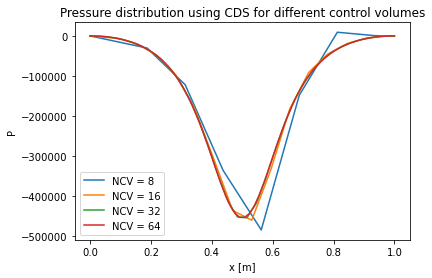

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax = plt.subplots()


ax.plot(grid1, P_CDS8, label="NCV = 8")
ax.plot(grid2, P_CDS16, label="NCV = 16")
ax.plot(grid3, P_CDS32, label="NCV = 32")
ax.plot(grid4, P_CDS64, label="NCV = 64")


ax.set_title("Pressure distribution using CDS for different control volumes")
ax.set_xlabel("x [m]")
ax.set_ylabel("P")
ax.legend()
plt.show()

## Velocity distribution for different numbr of control volumes

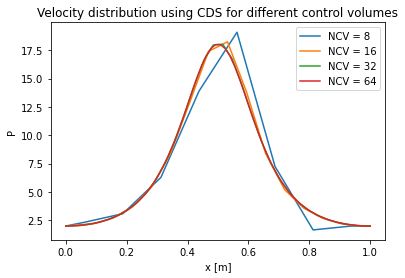

In [201]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2, ax = plt.subplots()


ax.plot(grid1, U_CDS8, label="NCV = 8")
ax.plot(grid2, U_CDS16, label="NCV = 16")
ax.plot(grid3, U_CDS32, label="NCV = 32")
ax.plot(grid4, U_CDS64, label="NCV = 64")


ax.set_title("Velocity distribution using CDS for different control volumes")
ax.set_xlabel("x [m]")
ax.set_ylabel("P")
ax.legend()
plt.show()

### Discussion on grid independence for CDS

As expected, considering the geometry of the duct, is possible to notice how in the pressure plot for the different control values, close to the middle of the lengt where, where the duct has the curve, the pressure distribution is dropped. Due to the converging-diverging geometry of the duct is possible to confirm that a number of control volumes higher than 32 is necessary to obtain more accurate results. After this number of control volumes the solution is independent. 
Same situation is possible to notice on the velocity distribution using the CDS scheme, where for a number of control volumes of 8, the solution has a noticeable difference with the expected velocity, where the accuracy is reduced. 

## Using QUICK scheme for the advection model

In [202]:
def QUICK (ncv1):
    from Classes.GridGeom import GridGeom
    from Classes.ScalarCoeffs import ScalarCoeffs
    from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
    from Classes.Models import DiffusionModel
    from Classes.LinearSolver import solve

    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 1
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = GridGeom(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 50
    dt = 0.01
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    mu = 1e-3

    # Define the coefficients
    PU_coeffs = ScalarCoeffs(grid.ncv)
    PP_coeffs = ScalarCoeffs(grid.ncv)
    UP_coeffs = ScalarCoeffs(grid.ncv)
    UU_coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    U0 = 2
    P0 = 0

    # Initialize field variable arrays
    U = U0*np.ones(grid.ncv+2)
    P = P0*np.ones(grid.ncv+2)

    # Initialize advecting velocity and damping coefficient array
    dhat = np.zeros(grid.ncv+1)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions for velocity
    U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
    U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

    # Define boundary conditions for pressure
    P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
    #P_west_bc = NeumannBc(P, grid, 0, BoundaryLocation.WEST)
    P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    U_west_bc.apply()
    U_east_bc.apply()
    P_west_bc.apply()
    P_east_bc.apply()

    # Define the transient model
    Uold = np.copy(U)
    transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

    # Define the advection model
    advection = QUICKAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

    # Define the pressure force model
    pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

    # Define advecting velocity model
    advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

    # Define conservation of mass equation
    mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, P_west_bc, P_east_bc, U_west_bc, U_east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" velocity field
        Uold[:] = U[:]

        # Iterate until the solution is converged
        for i in range(maxIter):

            # Zero all of the equations
            PP_coeffs.zero()
            PU_coeffs.zero()
            UU_coeffs.zero()
            UP_coeffs.zero()     

            # Assemble the momentum equations
            #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
            UU_coeffs = diffusion.add(UU_coeffs)
            UU_coeffs = advection.add(UU_coeffs)
            UU_coeffs = transient.add(UU_coeffs)
            UP_coeffs = pressure.add(UP_coeffs)

            # Assemble the mass equations
            advecting.update()
            PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

            # Compute residuals and check for convergence
            PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
            PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
            UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
            UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
            print("Iteration = {}.".format(i))
            print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
            print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
            if PmaxResid < converged and UmaxResid < converged:
                break

            # Solve the sparse matrix system
            dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

            # Update the solutions 
            P[1:-1] += dP
            U[1:-1] += dU

            # Update boundary conditions
            U_west_bc.apply()
            U_east_bc.apply()
            P_west_bc.apply()
            P_east_bc.apply()

            # Update the advecting velocities
            advecting.update()

    return (P,U,grid.xP)

In [203]:
P_QUICK8, U_QUICK8, grid1 = QUICK (8)

#To calculate the pressure difference between inlet and outlet of the domain to estimate the dynamic loss
Pdif_QK8 = P_QUICK8[0] - P_QUICK8[-1]
print (Pdif_QK8)

Timestep = 0; Time = 0.01
Iteration = 0.
  Mass:     Max. Resid. = 2.0913124406223265; Avg. Resid. = 1.2566370614359172
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 2.3741603228261745; Avg. Resid. = 1.3469815512297052
  Momentum: Max. Resid. = 14.296003941565713; Avg. Resid. = 7.702399370848074
Iteration = 2.
  Mass:     Max. Resid. = 4.120460388623589; Avg. Resid. = 1.5113762909678545
  Momentum: Max. Resid. = 16.310129607888474; Avg. Resid. = 6.060675920452848
Iteration = 3.
  Mass:     Max. Resid. = 2.134156523627829; Avg. Resid. = 1.1381684041145614
  Momentum: Max. Resid. = 10.142194660617736; Avg. Resid. = 4.890922010329197
Iteration = 4.
  Mass:     Max. Resid. = 3.6725599821155197; Avg. Resid. = 1.1989141814523658
  Momentum: Max. Resid. = 20.034220051459904; Avg. Resid. = 4.806436492248492
Iteration = 5.
  Mass:     Max. Resid. = 2.7581765704507655; Avg. Resid. = 0.878716263548404
  Momentum: Max. Resid. = 13.326555663358178; Avg. R

Iteration = 2.
  Mass:     Max. Resid. = 1.6390369506069646e-07; Avg. Resid. = 7.34381644384996e-08
  Momentum: Max. Resid. = 1.0249553872299089e-06; Avg. Resid. = 4.338790094982059e-07
Iteration = 3.
  Mass:     Max. Resid. = 1.472208595032498e-07; Avg. Resid. = 6.80279612641499e-08
  Momentum: Max. Resid. = 1.991080715413318e-06; Avg. Resid. = 6.18628757775852e-07
Iteration = 4.
  Mass:     Max. Resid. = 2.2877173666557837e-07; Avg. Resid. = 8.929302652838089e-08
  Momentum: Max. Resid. = 1.3670826781719825e-06; Avg. Resid. = 4.714680850170794e-07
Iteration = 5.
  Mass:     Max. Resid. = 1.3592805636619687e-07; Avg. Resid. = 4.1238776393726084e-08
  Momentum: Max. Resid. = 7.38912284248272e-07; Avg. Resid. = 1.6116959999923353e-07
Timestep = 10; Time = 0.10999999999999999
Iteration = 0.
  Mass:     Max. Resid. = 1.3549378774513343e-07; Avg. Resid. = 4.10780087722884e-08
  Momentum: Max. Resid. = 7.130744439365344e-07; Avg. Resid. = 1.658728886466676e-07
Timestep = 11; Time = 0.119999

In [204]:
P_QUICK16, U_QUICK16, grid2 = QUICK (16)
#To calculate the pressure difference between inlet and outlet of the domain to estimate the dynamic loss
Pdif_QK16 = P_QUICK16[0] - P_QUICK16[-1]
print (Pdif_QK16)

Timestep = 0; Time = 0.01
Iteration = 0.
  Mass:     Max. Resid. = 1.0538034862660162; Avg. Resid. = 0.6283185307179586
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 1.8838911288179467; Avg. Resid. = 0.6401212260966987
  Momentum: Max. Resid. = 14.830449231786181; Avg. Resid. = 5.216019814861222
Iteration = 2.
  Mass:     Max. Resid. = 1.3888826355291881; Avg. Resid. = 0.4951581106103884
  Momentum: Max. Resid. = 8.933169667622291; Avg. Resid. = 2.6215008619856377
Iteration = 3.
  Mass:     Max. Resid. = 1.708305205920484; Avg. Resid. = 0.6138788191835922
  Momentum: Max. Resid. = 7.364800330195333; Avg. Resid. = 2.262345491670909
Iteration = 4.
  Mass:     Max. Resid. = 1.147745652833982; Avg. Resid. = 0.43991569910758105
  Momentum: Max. Resid. = 6.7837267734907165; Avg. Resid. = 2.0842876796696777
Iteration = 5.
  Mass:     Max. Resid. = 1.4226045151051192; Avg. Resid. = 0.37786515053427727
  Momentum: Max. Resid. = 8.127351756117159; Avg.

Iteration = 8.
  Mass:     Max. Resid. = 6.19195021478447e-07; Avg. Resid. = 1.7051660639033628e-07
  Momentum: Max. Resid. = 9.818313726484007e-07; Avg. Resid. = 4.821932667042894e-07
Timestep = 5; Time = 0.060000000000000005
Iteration = 0.
  Mass:     Max. Resid. = 6.179197207245579e-07; Avg. Resid. = 1.7049476919162032e-07
  Momentum: Max. Resid. = 2.3351459634390892e-05; Avg. Resid. = 6.642158288536204e-06
Iteration = 1.
  Mass:     Max. Resid. = 1.057493200562476e-06; Avg. Resid. = 2.539065629969528e-07
  Momentum: Max. Resid. = 1.1747289352825874e-05; Avg. Resid. = 3.3314745715301575e-06
Iteration = 2.
  Mass:     Max. Resid. = 1.8453031547238652e-07; Avg. Resid. = 6.122555928911311e-08
  Momentum: Max. Resid. = 5.859424366150279e-06; Avg. Resid. = 1.6133239291310497e-06
Iteration = 3.
  Mass:     Max. Resid. = 1.8552933678250838e-07; Avg. Resid. = 4.527421582078972e-08
  Momentum: Max. Resid. = 2.718541932011931e-06; Avg. Resid. = 8.071760774774894e-07
Iteration = 4.
  Mass:    

Iteration = 0.
  Mass:     Max. Resid. = 1.2779100444504365e-08; Avg. Resid. = 3.376425361523161e-09
  Momentum: Max. Resid. = 6.585008129889047e-07; Avg. Resid. = 2.3472241705152497e-07
0.06774825427419273


In [205]:
P_QUICK32, U_QUICK32, grid3 = QUICK (32)
#To calculate the pressure difference between inlet and outlet of the domain to estimate the dynamic loss
Pdif_QK32 = P_QUICK32[0] - P_QUICK32[-1]
print (Pdif_QK32)

Timestep = 0; Time = 0.01
Iteration = 0.
  Mass:     Max. Resid. = 0.5395740781751108; Avg. Resid. = 0.3141592653589793
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 2.5888543199857086; Avg. Resid. = 0.29843611977294104
  Momentum: Max. Resid. = 17.068995175091334; Avg. Resid. = 3.2008945608703376
Iteration = 2.
  Mass:     Max. Resid. = 1.3466539125397183; Avg. Resid. = 0.19785316399113834
  Momentum: Max. Resid. = 3.4312903484905863; Avg. Resid. = 0.9898523422540855
Iteration = 3.
  Mass:     Max. Resid. = 1.2563685666391615; Avg. Resid. = 0.15155552738125092
  Momentum: Max. Resid. = 2.9998438032745685; Avg. Resid. = 0.6884361442674729
Iteration = 4.
  Mass:     Max. Resid. = 0.9612396727542656; Avg. Resid. = 0.12085444575667492
  Momentum: Max. Resid. = 6.5594896244584175; Avg. Resid. = 0.6442396956795364
Iteration = 5.
  Mass:     Max. Resid. = 0.19392635773497258; Avg. Resid. = 0.05338347207522512
  Momentum: Max. Resid. = 4.12435016772

Iteration = 0.
  Mass:     Max. Resid. = 6.264218921359088e-07; Avg. Resid. = 9.564009501028536e-08
  Momentum: Max. Resid. = 9.538604263670258e-07; Avg. Resid. = 2.0368307264082008e-07
Timestep = 36; Time = 0.37000000000000016
Iteration = 0.
  Mass:     Max. Resid. = 6.264218921359088e-07; Avg. Resid. = 9.564009501028536e-08
  Momentum: Max. Resid. = 9.538604263670258e-07; Avg. Resid. = 2.0368307264082008e-07
Timestep = 37; Time = 0.38000000000000017
Iteration = 0.
  Mass:     Max. Resid. = 6.264218921359088e-07; Avg. Resid. = 9.564009501028536e-08
  Momentum: Max. Resid. = 9.538604263670258e-07; Avg. Resid. = 2.0368307264082008e-07
Timestep = 38; Time = 0.3900000000000002
Iteration = 0.
  Mass:     Max. Resid. = 6.264218921359088e-07; Avg. Resid. = 9.564009501028536e-08
  Momentum: Max. Resid. = 9.538604263670258e-07; Avg. Resid. = 2.0368307264082008e-07
Timestep = 39; Time = 0.4000000000000002
Iteration = 0.
  Mass:     Max. Resid. = 6.264218921359088e-07; Avg. Resid. = 9.5640095010

In [206]:
P_QUICK64, U_QUICK64, grid4 = QUICK (64)
#To calculate the pressure difference between inlet and outlet of the domain to estimate the dynamic loss
Pdif_QK64 = P_QUICK64[0] - P_QUICK64[-1]
print (Pdif_QK64)

Timestep = 0; Time = 0.01
Iteration = 0.
  Mass:     Max. Resid. = 0.2712931358664763; Avg. Resid. = 0.15707963267948966
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 3.1046426383448065; Avg. Resid. = 0.1389819158437354
  Momentum: Max. Resid. = 19.406679158719854; Avg. Resid. = 1.918271671121386
Iteration = 2.
  Mass:     Max. Resid. = 1.368896985763107; Avg. Resid. = 0.07354864389687177
  Momentum: Max. Resid. = 3.4636054059992514; Avg. Resid. = 0.3413147261521897
Iteration = 3.
  Mass:     Max. Resid. = 1.1224386942924243; Avg. Resid. = 0.05241329955773537
  Momentum: Max. Resid. = 0.7338487791117303; Avg. Resid. = 0.19129603142699755
Iteration = 4.
  Mass:     Max. Resid. = 0.3419619390889448; Avg. Resid. = 0.020075492136505807
  Momentum: Max. Resid. = 4.317687473117575; Avg. Resid. = 0.14562966147881148
Iteration = 5.
  Mass:     Max. Resid. = 0.210072096850749; Avg. Resid. = 0.012913791911889405
  Momentum: Max. Resid. = 1.445930884443

Iteration = 0.
  Mass:     Max. Resid. = 6.8301366518142e-07; Avg. Resid. = 1.000823975083609e-07
  Momentum: Max. Resid. = 8.235682031898506e-07; Avg. Resid. = 1.5105341438689237e-07
Timestep = 6; Time = 0.07
Iteration = 0.
  Mass:     Max. Resid. = 6.8301366518142e-07; Avg. Resid. = 1.000823975083609e-07
  Momentum: Max. Resid. = 8.235681818735685e-07; Avg. Resid. = 1.5105341016804488e-07
Timestep = 7; Time = 0.08
Iteration = 0.
  Mass:     Max. Resid. = 6.8301366518142e-07; Avg. Resid. = 1.000823975083609e-07
  Momentum: Max. Resid. = 8.235681818735685e-07; Avg. Resid. = 1.5105341016804488e-07
Timestep = 8; Time = 0.09
Iteration = 0.
  Mass:     Max. Resid. = 6.8301366518142e-07; Avg. Resid. = 1.000823975083609e-07
  Momentum: Max. Resid. = 8.235681818735685e-07; Avg. Resid. = 1.5105341016804488e-07
Timestep = 9; Time = 0.09999999999999999
Iteration = 0.
  Mass:     Max. Resid. = 6.8301366518142e-07; Avg. Resid. = 1.000823975083609e-07
  Momentum: Max. Resid. = 8.235681818735685e-07

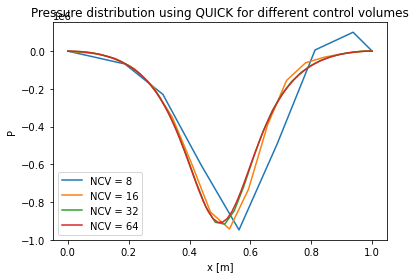

In [207]:
%matplotlib inline
import matplotlib.pyplot as plt

fig3, ax = plt.subplots()


ax.plot(grid1, P_QUICK8, label="NCV = 8")
ax.plot(grid2, P_QUICK16, label="NCV = 16")
ax.plot(grid3, P_QUICK32, label="NCV = 32")
ax.plot(grid4, P_QUICK64, label="NCV = 64")


ax.set_title("Pressure distribution using QUICK for different control volumes")
ax.set_xlabel("x [m]")
ax.set_ylabel("P")
ax.legend()
plt.show()

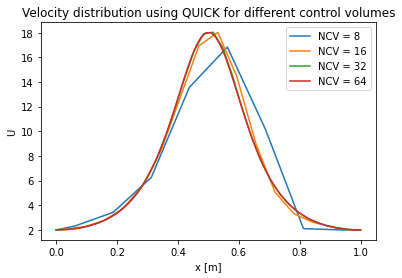

In [208]:
%matplotlib inline
import matplotlib.pyplot as plt

fig4, ax = plt.subplots()


ax.plot(grid1, U_QUICK8, label="NCV = 8")
ax.plot(grid2, U_QUICK16, label="NCV = 16")
ax.plot(grid3, U_QUICK32, label="NCV = 32")
ax.plot(grid4, U_QUICK64, label="NCV = 64")


ax.set_title("Velocity distribution using QUICK for different control volumes")
ax.set_xlabel("x [m]")
ax.set_ylabel("U")
ax.legend()
plt.show()

### Grid indepence analysis for QUICK

On the previous plots for pressure and velocity using the QUICK scheme, it was possible to notice the same behaviour than with the CDS scheme, where the results are independent of the grid after a number of control volumes of 32. Similar distribution is noticed for pressure and velocity as the ones obtained on the CDS scheme, with the difference that for the QUICK scheme, the pressure distribution on in the centre of the duct is higher than the one obtained on the CDS scheme, this difference is more noticeable in the following plot where all the schemes are compared with the solution obtained using UDS. 

## Using UDS for the advection model

In [209]:
def UDS (ncv1):
    from Classes.GridGeom import GridGeom
    from Classes.ScalarCoeffs import ScalarCoeffs
    from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
    from Classes.Models import DiffusionModel
    from Classes.LinearSolver import solve

    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 1
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = GridGeom(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 50
    dt = 0.01
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    mu = 1e-3

    # Define the coefficients
    PU_coeffs = ScalarCoeffs(grid.ncv)
    PP_coeffs = ScalarCoeffs(grid.ncv)
    UP_coeffs = ScalarCoeffs(grid.ncv)
    UU_coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    U0 = 2
    P0 = 0

    # Initialize field variable arrays
    U = U0*np.ones(grid.ncv+2)
    P = P0*np.ones(grid.ncv+2)

    # Initialize advecting velocity and damping coefficient array
    dhat = np.zeros(grid.ncv+1)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions for velocity
    U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
    U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

    # Define boundary conditions for pressure
    P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
    #P_west_bc = NeumannBc(P, grid, 0, BoundaryLocation.WEST)
    P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    U_west_bc.apply()
    U_east_bc.apply()
    P_west_bc.apply()
    P_east_bc.apply()

    # Define the transient model
    Uold = np.copy(U)
    transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

    # Define the advection model
    advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

    # Define the pressure force model
    pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

    # Define advecting velocity model
    advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

    # Define conservation of mass equation
    mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, P_west_bc, P_east_bc, U_west_bc, U_east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" velocity field
        Uold[:] = U[:]

        # Iterate until the solution is converged
        for i in range(maxIter):

            # Zero all of the equations
            PP_coeffs.zero()
            PU_coeffs.zero()
            UU_coeffs.zero()
            UP_coeffs.zero()     

            # Assemble the momentum equations
            #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
            UU_coeffs = diffusion.add(UU_coeffs)
            UU_coeffs = advection.add(UU_coeffs)
            UU_coeffs = transient.add(UU_coeffs)
            UP_coeffs = pressure.add(UP_coeffs)

            # Assemble the mass equations
            advecting.update()
            PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

            # Compute residuals and check for convergence
            PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
            PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
            UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
            UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
            print("Iteration = {}.".format(i))
            print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
            print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
            if PmaxResid < converged and UmaxResid < converged:
                break

            # Solve the sparse matrix system
            dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

            # Update the solutions 
            P[1:-1] += dP
            U[1:-1] += dU

            # Update boundary conditions
            U_west_bc.apply()
            U_east_bc.apply()
            P_west_bc.apply()
            P_east_bc.apply()

            # Update the advecting velocities
            advecting.update()
            
    return (P,U,grid.xP)

In [210]:
P_UDS1, U_UDS1, grid_uds = UDS (64)
#To calculate the pressure difference between inlet and outlet of the domain to estimate the dynamic loss
Pdif_UDS = P_UDS1[0] - P_UDS1[-1]
print (Pdif_UDS)

Timestep = 0; Time = 0.01
Iteration = 0.
  Mass:     Max. Resid. = 0.2712931358664763; Avg. Resid. = 0.15707963267948966
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 3.1046426383448065; Avg. Resid. = 0.1389819158437354
  Momentum: Max. Resid. = 17.165241546979935; Avg. Resid. = 1.8118744151049182
Iteration = 2.
  Mass:     Max. Resid. = 1.3500700033561843; Avg. Resid. = 0.07221863237373828
  Momentum: Max. Resid. = 2.9507037604599304; Avg. Resid. = 0.3029921053500737
Iteration = 3.
  Mass:     Max. Resid. = 1.1849220386333874; Avg. Resid. = 0.050597254761791124
  Momentum: Max. Resid. = 0.5026301432503102; Avg. Resid. = 0.16321984747034704
Iteration = 4.
  Mass:     Max. Resid. = 0.3113517020302874; Avg. Resid. = 0.015832195056466228
  Momentum: Max. Resid. = 3.5376374909208943; Avg. Resid. = 0.09751676944248124
Iteration = 5.
  Mass:     Max. Resid. = 0.199242333457887; Avg. Resid. = 0.009467808072574399
  Momentum: Max. Resid. = 1.58196272

### Calculation of the pressure difference between the inlet and outlet of the duct for each of the schemes

Considering the equation to calculate the dynamic head loss on the duct, the following calculation represents the pressure difference obtained for each of the schemes used on the advection model. Based on the geometry of the duct, is expected that this dynamic head loss is almost zero, since the pressure in the inlet and in the outlet should be the same because the shear model is not being considerate for this case. 
On this pressure difference calculation, is possible to notice that the scheme that has a better approach to a zero difference is the UDS scheme, which achieves an steady state after the third time step. The QUICK scheme is the next closest value to zero from this difference, and it is possible to notice that this scheme achieves a steady state after the forth time step. The CDS scheme is the one that takes longer to achieve steady state, since it takes up to the time step 42; the pressure difference obtained from this scheme is not as differentiated from QUICK as it is from the UDS. All the schemes have the same time set up in order to compare the convergence of each of them.

In [214]:
print ("Pressure difference for CDS is: ", Pdif_CDS64)
print ("Pressure difference for QUICK is: ", Pdif_QK64)
print ("Pressure difference for UDS is: ", Pdif_UDS)

Pressure difference for CDS is:  0.015497901788620538
Pressure difference for QUICK is:  0.01386431128150889
Pressure difference for UDS is:  0.012404408469180339


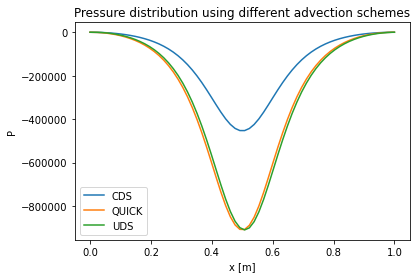

In [215]:
%matplotlib inline
import matplotlib.pyplot as plt

fig5, ax = plt.subplots()


ax.plot(grid4, P_CDS64, label="CDS")
ax.plot(grid4, P_QUICK64, label="QUICK")
ax.plot(grid_uds, P_UDS1, label="UDS")




ax.set_title("Pressure distribution using different advection schemes")
ax.set_xlabel("x [m]")
ax.set_ylabel("P")
ax.legend()
plt.show()

### Discussion problem 3

Based on the dynamic head loss equation defined on the description of the problem, is possible to notice that with the different in the pressures at the inlet and at the outlet is possible to estimate the value of Cd. Considering the geometry of the problem, a converging-diverging circular duct, is to expect that the pressure at the inlet and outlet of the duct (where the cross section area is uniform), will be the same since the friction of the wall is not being considerate in this problem. 
So is expected that the dynamic head loss is close to a value of zero. As previously mentioned, the scheme that is closer to this value of difference pressure is the UDS scheme. On the previous plot, is possible to notice how the QUICK and the UDS scheme provide closer results between them compared with the CDS scheme. For this case where a converging-diverging geometry is being used, the second-order advection scheme that is closer to the result is shown to be the QUICK scheme, wich proves that the errors associated with UDS (first order scheme) are minimal and close enough to the second order scheme as QUICK since CDS seems to have a higher error associated with it for this type of problems. 